# LIGHT GBM

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing
import lightgbm as lgb

In [29]:
labels = pd.read_csv('../../csv/train_labels.csv')
labels.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [30]:
values = pd.read_csv('../../csv/train_values.csv')
values.T

,0,1,2,3,4,5,6,7,8,9,...,260591,260592,260593,260594,260595,260596,260597,260598,260599,260600
building_id,802906,28830,94947,590882,201944,333020,728451,475515,441126,989500,...,560805,207683,226421,159555,827012,688636,669485,602512,151409,747594
geo_level_1_id,6,8,21,22,11,8,9,20,0,26,...,20,10,8,27,8,25,17,17,26,21
geo_level_2_id,487,900,363,418,131,558,475,323,757,886,...,368,1382,767,181,268,1335,715,51,39,9
geo_level_3_id,12198,2812,8973,10694,1488,6089,12066,12236,7219,994,...,5980,1903,8613,1537,4718,1621,2060,8163,1851,9101
count_floors_pre_eq,2,2,2,2,3,2,2,2,2,1,...,1,2,2,6,2,1,2,3,2,3
age,30,10,10,10,30,10,25,0,15,0,...,25,25,5,0,20,55,0,55,10,10
area_percentage,6,8,5,6,8,9,3,8,8,13,...,5,5,13,13,8,6,6,6,14,7
height_percentage,5,7,5,5,9,5,4,6,6,4,...,3,5,5,12,5,3,5,7,6,6
land_surface_condition,t,o,t,t,t,t,n,t,t,t,...,n,t,t,t,t,n,t,t,t,n
foundation_type,r,r,r,r,r,r,r,w,r,i,...,r,r,r,r,r,r,r,r,r,r


In [31]:
values["building_id"].count() == values["building_id"].drop_duplicates().count()

True

In [32]:
to_be_categorized = ["land_surface_condition", "foundation_type", "roof_type",\
                     "position", "ground_floor_type", "other_floor_type",\
                     "plan_configuration", "legal_ownership_status"]
for row in to_be_categorized:
    values[row] = values[row].astype("category")

In [33]:
datatypes = dict(values.dtypes)
for row in values.columns:
    if datatypes[row] != "int64" and datatypes[row] != "int32" and \
       datatypes[row] != "int16" and datatypes[row] != "int8":
        continue
    if values[row].nlargest(1).item() > 32767 and values[row].nlargest(1).item() < 2**31:
        values[row] = values[row].astype(np.int32)
    elif values[row].nlargest(1).item() > 127:
        values[row] = values[row].astype(np.int16)
    else:
        values[row] = values[row].astype(np.int8)

In [34]:
labels["building_id"] = labels["building_id"].astype(np.int32)
labels["damage_grade"] = labels["damage_grade"].astype(np.int8)

In [35]:
important_values = values\
                .merge(labels, on="building_id")
important_values.drop(columns=["building_id"], inplace = True)
important_values["geo_level_1_id"] = important_values["geo_level_1_id"].astype("category")

In [36]:
X_train, X_test, y_train, y_test = train_test_split(important_values.drop(columns = 'damage_grade'),
                                                    important_values['damage_grade'], test_size = 0.2, random_state = 123)

In [37]:
from sklearn.utils import class_weight

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

classes_weights

array([0.58539434, 0.58539434, 0.99663454, ..., 0.99663454, 0.99663454,
       0.99663454])

In [38]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

features_to_encode = ["geo_level_1_id", "land_surface_condition", "foundation_type", "roof_type",\
                     "position", "ground_floor_type", "other_floor_type",\
                     "plan_configuration", "legal_ownership_status"]
for feature in features_to_encode:
    X_train = encode_and_bind(X_train, feature)
    X_test = encode_and_bind(X_test, feature)

In [42]:
clf = lgb.LGBMClassifier(boosting_type='gbdt', 
                         colsample_bytree=1.0,
                         importance_type='split', 
                         learning_rate=0.15,
                         max_depth=None,
                         n_estimators=1600, 
                         n_jobs=-1,
                         objective=None,
                         subsample=1.0, 
                         subsample_for_bin=200000, 
                         subsample_freq=0)
clf.fit(X_train, y_train, 
          categorical_feature=['geo_level_2_id', 'geo_level_3_id'],
          eval_set=(X_test,y_test))

/home/joaquinfontela/.local/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/joaquinfontela/.local/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['geo_level_2_id', 'geo_level_3_id']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/home/joaquinfontela/.local/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/joaquinfontela/.local/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's multi_logloss: 0.82916
[2]	valid_0's multi_logloss: 0.774185
[3]	valid_0's multi_logloss: 0.734844
[4]	valid_0's multi_logloss: 0.705528
[5]	valid_0's multi_logloss: 0.683363
[6]	valid_0's multi_logloss: 0.6661
[7]	valid_0's multi_logloss: 0.652038
[8]	valid_0's multi_logloss: 0.64062
[9]	valid_0's multi_logloss: 0.631663
[10]	valid_0's multi_logloss: 0.624419
[11]	valid_0's multi_logloss: 0.618042
[12]	valid_0's multi_logloss: 0.612826
[13]	valid_0's multi_logloss: 0.608143
[14]	valid_0's multi_logloss: 0.604391
[15]	valid_0's multi_logloss: 0.601189
[16]	valid_0's multi_logloss: 0.598009
[17]	valid_0's multi_logloss: 0.595157
[18]	valid_0's multi_logloss: 0.592873
[19]	valid_0's multi_logloss: 0.590405
[20]	valid_0's multi_logloss: 0.588337
[21]	valid_0's multi_logloss: 0.586582
[22]	valid_0's multi_logloss: 0.584919
[23]	valid_0's multi_logloss: 0.583418
[24]	valid_0's multi_logloss: 0.581888
[25]	valid_0's multi_logloss: 0.580724
[26]	valid_0's multi_logloss: 0.579395

[216]	valid_0's multi_logloss: 0.574245
[217]	valid_0's multi_logloss: 0.574324
[218]	valid_0's multi_logloss: 0.574464
[219]	valid_0's multi_logloss: 0.574496
[220]	valid_0's multi_logloss: 0.5745
[221]	valid_0's multi_logloss: 0.574547
[222]	valid_0's multi_logloss: 0.574631
[223]	valid_0's multi_logloss: 0.574646
[224]	valid_0's multi_logloss: 0.574677
[225]	valid_0's multi_logloss: 0.574731
[226]	valid_0's multi_logloss: 0.574788
[227]	valid_0's multi_logloss: 0.574775
[228]	valid_0's multi_logloss: 0.574817
[229]	valid_0's multi_logloss: 0.57481
[230]	valid_0's multi_logloss: 0.574868
[231]	valid_0's multi_logloss: 0.57491
[232]	valid_0's multi_logloss: 0.57495
[233]	valid_0's multi_logloss: 0.574966
[234]	valid_0's multi_logloss: 0.574976
[235]	valid_0's multi_logloss: 0.575062
[236]	valid_0's multi_logloss: 0.575071
[237]	valid_0's multi_logloss: 0.575086
[238]	valid_0's multi_logloss: 0.575137
[239]	valid_0's multi_logloss: 0.575161
[240]	valid_0's multi_logloss: 0.575294
[241]

[422]	valid_0's multi_logloss: 0.580669
[423]	valid_0's multi_logloss: 0.580664
[424]	valid_0's multi_logloss: 0.58068
[425]	valid_0's multi_logloss: 0.580678
[426]	valid_0's multi_logloss: 0.580697
[427]	valid_0's multi_logloss: 0.58072
[428]	valid_0's multi_logloss: 0.58077
[429]	valid_0's multi_logloss: 0.580806
[430]	valid_0's multi_logloss: 0.580873
[431]	valid_0's multi_logloss: 0.580868
[432]	valid_0's multi_logloss: 0.580894
[433]	valid_0's multi_logloss: 0.580966
[434]	valid_0's multi_logloss: 0.580978
[435]	valid_0's multi_logloss: 0.580992
[436]	valid_0's multi_logloss: 0.581046
[437]	valid_0's multi_logloss: 0.581078
[438]	valid_0's multi_logloss: 0.581107
[439]	valid_0's multi_logloss: 0.581122
[440]	valid_0's multi_logloss: 0.581161
[441]	valid_0's multi_logloss: 0.581186
[442]	valid_0's multi_logloss: 0.581214
[443]	valid_0's multi_logloss: 0.581217
[444]	valid_0's multi_logloss: 0.581239
[445]	valid_0's multi_logloss: 0.581323
[446]	valid_0's multi_logloss: 0.581385
[44

[633]	valid_0's multi_logloss: 0.586764
[634]	valid_0's multi_logloss: 0.586777
[635]	valid_0's multi_logloss: 0.586828
[636]	valid_0's multi_logloss: 0.586833
[637]	valid_0's multi_logloss: 0.586834
[638]	valid_0's multi_logloss: 0.586845
[639]	valid_0's multi_logloss: 0.586872
[640]	valid_0's multi_logloss: 0.58689
[641]	valid_0's multi_logloss: 0.586893
[642]	valid_0's multi_logloss: 0.586925
[643]	valid_0's multi_logloss: 0.58691
[644]	valid_0's multi_logloss: 0.586918
[645]	valid_0's multi_logloss: 0.586952
[646]	valid_0's multi_logloss: 0.586966
[647]	valid_0's multi_logloss: 0.586999
[648]	valid_0's multi_logloss: 0.58702
[649]	valid_0's multi_logloss: 0.587067
[650]	valid_0's multi_logloss: 0.587105
[651]	valid_0's multi_logloss: 0.587138
[652]	valid_0's multi_logloss: 0.58714
[653]	valid_0's multi_logloss: 0.587185
[654]	valid_0's multi_logloss: 0.587194
[655]	valid_0's multi_logloss: 0.587211
[656]	valid_0's multi_logloss: 0.587232
[657]	valid_0's multi_logloss: 0.587263
[658

[844]	valid_0's multi_logloss: 0.591914
[845]	valid_0's multi_logloss: 0.591922
[846]	valid_0's multi_logloss: 0.591948
[847]	valid_0's multi_logloss: 0.59196
[848]	valid_0's multi_logloss: 0.591952
[849]	valid_0's multi_logloss: 0.591955
[850]	valid_0's multi_logloss: 0.591974
[851]	valid_0's multi_logloss: 0.592001
[852]	valid_0's multi_logloss: 0.59202
[853]	valid_0's multi_logloss: 0.592044
[854]	valid_0's multi_logloss: 0.592026
[855]	valid_0's multi_logloss: 0.592036
[856]	valid_0's multi_logloss: 0.592051
[857]	valid_0's multi_logloss: 0.592107
[858]	valid_0's multi_logloss: 0.592104
[859]	valid_0's multi_logloss: 0.592118
[860]	valid_0's multi_logloss: 0.59216
[861]	valid_0's multi_logloss: 0.592175
[862]	valid_0's multi_logloss: 0.592205
[863]	valid_0's multi_logloss: 0.592213
[864]	valid_0's multi_logloss: 0.592219
[865]	valid_0's multi_logloss: 0.592231
[866]	valid_0's multi_logloss: 0.592243
[867]	valid_0's multi_logloss: 0.592255
[868]	valid_0's multi_logloss: 0.592268
[86

[1051]	valid_0's multi_logloss: 0.596372
[1052]	valid_0's multi_logloss: 0.596378
[1053]	valid_0's multi_logloss: 0.596393
[1054]	valid_0's multi_logloss: 0.596461
[1055]	valid_0's multi_logloss: 0.59646
[1056]	valid_0's multi_logloss: 0.596475
[1057]	valid_0's multi_logloss: 0.596516
[1058]	valid_0's multi_logloss: 0.596543
[1059]	valid_0's multi_logloss: 0.596556
[1060]	valid_0's multi_logloss: 0.596588
[1061]	valid_0's multi_logloss: 0.596614
[1062]	valid_0's multi_logloss: 0.596636
[1063]	valid_0's multi_logloss: 0.596643
[1064]	valid_0's multi_logloss: 0.596639
[1065]	valid_0's multi_logloss: 0.596688
[1066]	valid_0's multi_logloss: 0.596715
[1067]	valid_0's multi_logloss: 0.596719
[1068]	valid_0's multi_logloss: 0.596769
[1069]	valid_0's multi_logloss: 0.596804
[1070]	valid_0's multi_logloss: 0.596817
[1071]	valid_0's multi_logloss: 0.596889
[1072]	valid_0's multi_logloss: 0.596909
[1073]	valid_0's multi_logloss: 0.596929
[1074]	valid_0's multi_logloss: 0.59693
[1075]	valid_0's m

[1251]	valid_0's multi_logloss: 0.60121
[1252]	valid_0's multi_logloss: 0.601256
[1253]	valid_0's multi_logloss: 0.601292
[1254]	valid_0's multi_logloss: 0.601324
[1255]	valid_0's multi_logloss: 0.601348
[1256]	valid_0's multi_logloss: 0.601397
[1257]	valid_0's multi_logloss: 0.601415
[1258]	valid_0's multi_logloss: 0.601462
[1259]	valid_0's multi_logloss: 0.60147
[1260]	valid_0's multi_logloss: 0.601463
[1261]	valid_0's multi_logloss: 0.601475
[1262]	valid_0's multi_logloss: 0.601517
[1263]	valid_0's multi_logloss: 0.601534
[1264]	valid_0's multi_logloss: 0.601581
[1265]	valid_0's multi_logloss: 0.601625
[1266]	valid_0's multi_logloss: 0.601664
[1267]	valid_0's multi_logloss: 0.601691
[1268]	valid_0's multi_logloss: 0.601723
[1269]	valid_0's multi_logloss: 0.601739
[1270]	valid_0's multi_logloss: 0.601771
[1271]	valid_0's multi_logloss: 0.601797
[1272]	valid_0's multi_logloss: 0.601809
[1273]	valid_0's multi_logloss: 0.60186
[1274]	valid_0's multi_logloss: 0.601867
[1275]	valid_0's mu

[1452]	valid_0's multi_logloss: 0.605535
[1453]	valid_0's multi_logloss: 0.605555
[1454]	valid_0's multi_logloss: 0.605598
[1455]	valid_0's multi_logloss: 0.605599
[1456]	valid_0's multi_logloss: 0.605623
[1457]	valid_0's multi_logloss: 0.605649
[1458]	valid_0's multi_logloss: 0.605654
[1459]	valid_0's multi_logloss: 0.605658
[1460]	valid_0's multi_logloss: 0.605678
[1461]	valid_0's multi_logloss: 0.605686
[1462]	valid_0's multi_logloss: 0.605706
[1463]	valid_0's multi_logloss: 0.605713
[1464]	valid_0's multi_logloss: 0.605734
[1465]	valid_0's multi_logloss: 0.605756
[1466]	valid_0's multi_logloss: 0.605781
[1467]	valid_0's multi_logloss: 0.605822
[1468]	valid_0's multi_logloss: 0.605834
[1469]	valid_0's multi_logloss: 0.605889
[1470]	valid_0's multi_logloss: 0.605914
[1471]	valid_0's multi_logloss: 0.605929
[1472]	valid_0's multi_logloss: 0.606029
[1473]	valid_0's multi_logloss: 0.606039
[1474]	valid_0's multi_logloss: 0.606049
[1475]	valid_0's multi_logloss: 0.606063
[1476]	valid_0's

LGBMClassifier(learning_rate=0.15, max_depth=None, n_estimators=1600)

In [ ]:
clf_pred = clf.predict(X_test)
f1_score(y_test, clf_pred, average='micro')

### Da peor balanceando los pesos.

In [15]:
test_values = pd.read_csv('../../csv/test_values.csv', index_col = "building_id")


In [16]:
test_values_subset = test_values
test_values_subset["geo_level_1_id"] = test_values_subset["geo_level_1_id"].astype("category")

In [17]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

features_to_encode = ["geo_level_1_id", "land_surface_condition", "foundation_type", "roof_type",\
                     "position", "ground_floor_type", "other_floor_type",\
                     "plan_configuration", "legal_ownership_status"]
for feature in features_to_encode:
    test_values_subset = encode_and_bind(test_values_subset, feature)


In [18]:
preds = clf.predict(test_values_subset)

In [19]:
submission_format = pd.read_csv('../../csv/submission_format.csv', index_col = "building_id")

In [20]:
my_submission = pd.DataFrame(data=df,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [19]:
df.to_csv('../../csv/predictions/LightGBM.csv')

<AxesSubplot:>

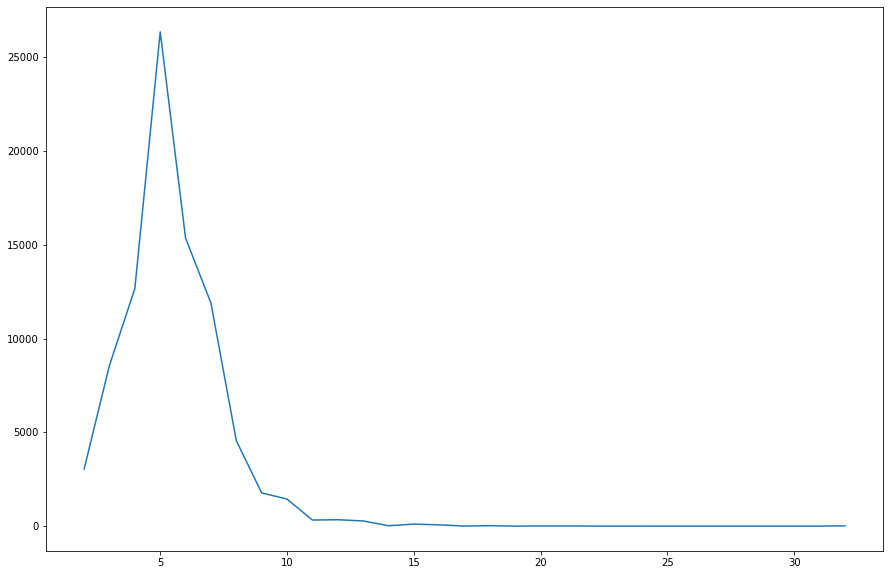

In [22]:
test_values_subset['height_percentage'].value_counts().sort_index().plot(figsize= (15, 10))

<AxesSubplot:>

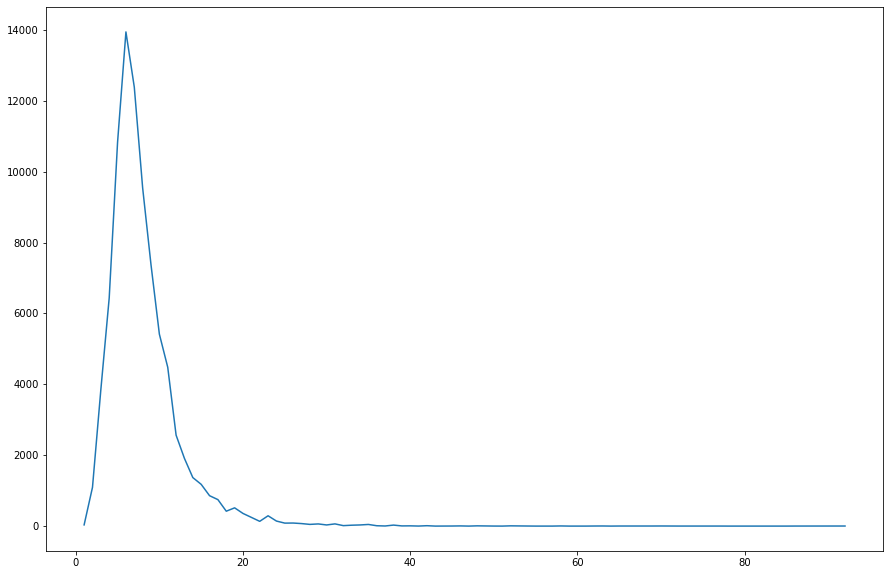

In [23]:
test_values_subset['area_percentage'].value_counts().sort_index().plot(figsize= (15, 10))